# Libraries

In [1]:
import os
import cv2 as cv
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import traceback
import matplotlib.pyplot as plt
import PIL as Image

# torch
import torch
import torchvision
from torchvision.ops import box_iou
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [8]:
class MuseumDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):

        self.root_dir = root_dir
        self.transforms = transforms

        # Load COCO annotation
        self.coco = COCO(annotation_file)

        # get images ids
        self.image_ids = list(sorted(self.coco.imgs.keys()))

        # Get category mapping
        self.category_ids = sorted(self.coco.getCatIds())
        print("Original category IDs:", self.category_ids)

        # Create a continuous mapping starting from 1 (0 is background)
        self.category_id_to_label = {}
        for idx, cat_id in enumerate(self.category_ids):
            self.category_id_to_label[cat_id] = idx + 1
        print("Category mapping:", self.category_id_to_label)

        # Verify all images exist
        # There's a chance that images are corrupt, so...you know, you should handle that
        self.valid_image_ids = []
        for img_id in self.image_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.root_dir, img_info['file_name'])
            if os.path.exists(img_path):
                self.valid_image_ids.append(img_id)

        print(f"Found {len(self.valid_image_ids)} valid images out of {len(self.image_ids)} total")

    def __len__(self):
        return len(self.valid_image_ids)

    def __getitem__(self, idx):
        # Load image
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])

        # Just in case the images are corrupt
        try:

            image = cv.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
        except Exception as e:
            print(f"Error loading image: {image_path}. {e}")
            return self.__getitem__((idx + 1) % len(self))


        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        # Handle empty annotations
        # Handle empty annotations
        # you marked some images with "no annotation" in roboflow. soooo, yeah it might
        # raise some error due to empty annotation. gotta check that out yo
        if len(anns) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([image_id]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
        else:
            for ann in anns:
                x, y, w, h = ann['bbox']
                x1 = max(x, 0)  # Ensure coordinates are not negative
                y1 = max(y, 0)
                x2 = min(x + w, image.shape[1])  # Ensure coordinates don't exceed image dimensions
                y2 = min(y + h, image.shape[0])

                # Skip invalid boxes
                if x2 <= x1 or y2 <= y1:
                    continue

                boxes.append([x1, y1, x2, y2])

                # Get category ID and map to model label
                label = self.category_id_to_label[ann['category_id']]
                labels.append(label)

            # Convert to tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([image_id]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }

        image = torch.as_tensor(image, dtype=torch.float32) / 255.0
        image = image.permute(2, 0, 1)

        return image, target

# Make a different class for readability man
def get_model(num_classes):

    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn(pretrained = True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Relace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def compute_ap(recalls, precisions):
    """ Compute the average precision, given the recall and precision curves"""
    ap = 0
    for t in np.arange(0.0, 1.0, 0.01):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])

        ap = ap + p / 11.


def validate(model, data_loader, device, iou_threshold=0.5):
    model.eval()

    # Dictionary to store all detections and ground truths
    all_detections = defaultdict(list)  # class_id -> list of detections
    all_ground_truths = defaultdict(list)  # class_id -> list of ground truths

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation"):
            images = list(image.to(device) for image in images)

            # Get predictions
            predictions = model(images)

            # Process each image in the batch
            for img_idx, (pred, target) in enumerate(zip(predictions, targets)):
                # Get predictions for this image
                boxes = pred['boxes'].cpu()
                scores = pred['scores'].cpu()
                labels = pred['labels'].cpu()

                # Get ground truth for this image
                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()

                # Store predictions and ground truths by class
                for box, score, label in zip(boxes, scores, labels):
                    all_detections[label.item()].append({
                        'box': box,
                        'score': score.item(),
                        'img_idx': img_idx
                    })

                for box, label in zip(gt_boxes, gt_labels):
                    all_ground_truths[label.item()].append({
                        'box': box,
                        'img_idx': img_idx,
                        'matched': False  # Add matched flag instead of modifying tensor
                    })

    # Calculate AP for each class
    aps = []
    class_metrics = {}
    mean_metrics = {'mAP': 0.0, 'mF1': 0.0, 'mPrecision': 0.0, 'mRecall': 0.0}

    print("\nCalculating AP for each class:")
    for class_id in all_ground_truths.keys():
        detections = all_detections[class_id]
        ground_truths = all_ground_truths[class_id]

        # Skip if no ground truths for this class
        if len(ground_truths) == 0:
            continue

        # Sort detections by score
        detections = sorted(detections, key=lambda x: x['score'], reverse=True)

        # Initialize arrays for precision-recall calculation
        tp = np.zeros(len(detections))
        fp = np.zeros(len(detections))

        # Create dictionary of ground truth boxes per image
        gt_per_img = defaultdict(list)
        for gt_idx, gt in enumerate(ground_truths):
            gt_per_img[gt['img_idx']].append({
                'box': gt['box'],
                'matched': False,
                'idx': gt_idx
            })

        # Match detections to ground truths
        for det_idx, detection in enumerate(detections):
            img_gt_boxes = gt_per_img[detection['img_idx']]

            if len(img_gt_boxes) == 0:
                fp[det_idx] = 1
                continue

            # Get all ground truth boxes for this image
            gt_boxes_tensor = torch.stack([gt['box'] for gt in img_gt_boxes])

            # Calculate IoU with all ground truth boxes
            iou = box_iou(detection['box'].unsqueeze(0), gt_boxes_tensor)

            if len(iou) > 0:
                max_iou = iou.max().item()
                max_idx = iou.argmax().item()

                if max_iou >= iou_threshold:
                    # If this ground truth wasn't matched before
                    if not img_gt_boxes[max_idx]['matched']:
                        tp[det_idx] = 1
                        # Mark this ground truth as matched
                        img_gt_boxes[max_idx]['matched'] = True
                        ground_truths[img_gt_boxes[max_idx]['idx']]['matched'] = True
                    else:
                        fp[det_idx] = 1
                else:
                    fp[det_idx] = 1
            else:
                fp[det_idx] = 1

        # Calculate precision and recall
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        total_tp = tp_cumsum[-1] if len(tp_cumsum) > 0 else 0
        total_fp = fp_cumsum[-1] if len(tp_cumsum) > 0 else 0
        total_fn = len(ground_truths) - total_tp
        
        # precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        precision = np.mean(tp_cumsum / (tp_cumsum + fp_cumsum)) if len(tp_cumsum) > 0 else 0
        recall = total_tp / len(ground_truths) if len(ground_truths) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Calculate AP using interpolation
        recalls_ap = tp_cumsum / len(ground_truths)
        precisions_ap = tp_cumsum / (tp_cumsum + fp_cumsum)
        
        # Add endpoints for AP calculation
        precisions_ap = np.concatenate([[1], precisions_ap])
        recalls_ap = np.concatenate([[0], recalls_ap])

        # Calculate AP for this class using interpolation
        ap = np.trapz(precisions_ap, recalls_ap)  # Using trapezoidal rule for AUC
        aps.append(ap)

        # Store metrics for this class
        class_metrics[class_id] = {
            'AP': ap,
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'TP': total_tp,
            'FP': total_fp,
            'FN': total_fn
        }
        # Add to mean metrics
        mean_metrics['mAP'] += ap
        mean_metrics['mF1'] += f1
        mean_metrics['mPrecision'] += precision
        mean_metrics['mRecall'] += recall

        print(f"Class {class_id}:")
        print(f"  AP = {ap:.4f}")
        print(f"  F1 = {f1:.4f}")
        print(f"  Precision = {precision:.4f}")
        print(f"  Recall = {recall:.4f}")
        print(f"  TP = {total_tp}, FP = {total_fp}, FN = {total_fn}")


    # Calculate mean metrics
    num_classes = len(class_metrics)
    if num_classes > 0:
        for key in mean_metrics:
            mean_metrics[key] /= num_classes

    print("\nMean Metrics:")
    print(f"mAP: {mean_metrics['mAP']:.4f}")
    print(f"mF1: {mean_metrics['mF1']:.4f}")
    print(f"mPrecision: {mean_metrics['mPrecision']:.4f}")
    print(f"mRecall: {mean_metrics['mRecall']:.4f}")

    return mean_metrics, class_metrics

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    valid_batches = 0

    for images, targets in tqdm(data_loader, desc="Training"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Skip batch if any target has no boxes
        if any(len(target['boxes']) == 0 for target in targets):
            continue

        try:
            loss_dict = model(images, targets)

            # Handle both dictionary and list cases
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
            elif isinstance(loss_dict, list):
                # Sum up all the losses in the list
                losses = sum(loss if isinstance(loss, torch.Tensor) else torch.tensor(loss, device=device)
                           for loss in loss_dict)
            else:
                print(f"Unexpected loss type: {type(loss_dict)}")
                continue

            # Skip iteration if loss is NaN
            if torch.isnan(losses):
                continue

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            valid_batches += 1

        except RuntimeError as e:
            print(f"Error in batch: {e}")
            continue

    return total_loss / valid_batches if valid_batches > 0 else float('inf')

def main():
    # Set device and enable blocking CUDA calls for better error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Dataset paths
    root_dir = "/kaggle/input/artgallerycounting/train"
    train_annotation = "/kaggle/input/artgallerycounting/train/_annotations.coco.json"
    val_root_dir = "/kaggle/input/artgallerycounting/valid"
    val_annotation = "/kaggle/input/artgallerycounting/valid/_annotations.coco.json"

    # Create datasets
    train_dataset = MuseumDataset(root_dir, train_annotation)
    val_dataset = MuseumDataset(val_root_dir, val_annotation)

    # Get number of classes
    num_classes = len(train_dataset.category_ids) + 1
    print(f"Number of classes (including background): {num_classes}")

    # Create data loaders with smaller batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=4
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=2
    )

    # Initialize model
    model = get_model(num_classes)
    model.to(device)

    # Initialize optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Initialize learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    num_epochs = 10
    best_map = 0.0

    # Lists to store metrics for plotting
    train_losses = []
    val_maps = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        try:
            # Train
            train_loss = train_one_epoch(model, optimizer, train_loader, device)
            print(f"Train Loss: {train_loss:.4f}")
            train_losses.append(train_loss)

            # Save checkpoint every N epochs
            if (epoch + 1) % 2 == 0:  # Save every 2 epochs
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                }, f'checkpoint_epoch_{epoch+1}.pth')

            # Validate with enhanced metrics
            mean_metrics, class_metrics = validate(model, val_loader, device)
            
            # Store metrics for plotting
            val_maps.append(mean_metrics['mAP'])
            val_f1s.append(mean_metrics['mF1'])
            val_precisions.append(mean_metrics['mPrecision'])
            val_recalls.append(mean_metrics['mRecall'])

            # Update learning rate
            lr_scheduler.step()

            # Save best model (now based on mAP)
            if mean_metrics['mAP'] > best_map:
                best_map = mean_metrics['mAP']
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_map': best_map,
                    'best_f1': mean_metrics['mF1'],
                    'best_precision': mean_metrics['mPrecision'],
                    'best_recall': mean_metrics['mRecall'],
                    'train_losses': train_losses,
                    'val_maps': val_maps,
                    'val_f1s': val_f1s,
                    'val_precisions': val_precisions,
                    'val_recalls': val_recalls,
                    'class_metrics': class_metrics
                }, 'best_model.pth')
                print("Saved best model checkpoint")

            # Plot training progress
            if epoch > 0:  # Plot after first epoch
                plt.figure(figsize=(15, 10))
                
                # Plot training loss
                plt.subplot(2, 2, 1)
                plt.plot(train_losses, label='Training Loss')
                plt.title('Training Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()

                # Plot validation metrics
                plt.subplot(2, 2, 2)
                plt.plot(val_maps, label='mAP')
                plt.plot(val_f1s, label='F1-Score')
                plt.plot(val_precisions, label='Precision')
                plt.plot(val_recalls, label='Recall')
                plt.title('Validation Metrics')
                plt.xlabel('Epoch')
                plt.ylabel('Score')
                plt.legend()

                plt.tight_layout()
                plt.savefig(f'training_progress_epoch_{epoch+1}.png')
                plt.close()

        except Exception as e:
            print(f"Error in epoch {epoch+1}: {e}")
            traceback.print_exc()
            
            # Save model even if validation fails
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_losses': train_losses,
                'val_maps': val_maps,
                'val_f1s': val_f1s,
                'val_precisions': val_precisions,
                'val_recalls': val_recalls
            }, f'backup_epoch_{epoch+1}.pth')
            continue

if __name__ == "__main__":
    main()

Using device: cuda
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Original category IDs: [0, 1, 2, 3, 4, 5]
Category mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}
Found 1113 valid images out of 1113 total
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Original category IDs: [0, 1, 2, 3, 4, 5]
Category mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}
Found 44 valid images out of 44 total
Number of classes (including background): 7

Epoch 1/10


Training: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s]


Train Loss: 0.7173


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.03it/s]



Calculating AP for each class:
Class 3:
  AP = 0.5841
  F1 = 0.3116
  Precision = 0.1864
  Recall = 0.9481
  TP = 73.0, FP = 1198.0, FN = 4.0
Class 4:
  AP = 0.7903
  F1 = 0.4428
  Precision = 0.2843
  Recall = 1.0000
  TP = 22.0, FP = 218.0, FN = 0.0
Class 2:
  AP = 0.3179
  F1 = 0.1918
  Precision = 0.1084
  Recall = 0.8286
  TP = 29.0, FP = 798.0, FN = 6.0
Class 5:
  AP = 0.0927
  F1 = 0.1723
  Precision = 0.0959
  Recall = 0.8500
  TP = 17.0, FP = 227.0, FN = 3.0

Mean Metrics:
mAP: 0.4462
mF1: 0.2796
mPrecision: 0.1688
mRecall: 0.9067
Saved best model checkpoint

Epoch 2/10


Training: 100%|██████████| 140/140 [00:58<00:00,  2.39it/s]


Train Loss: 0.4522


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]



Calculating AP for each class:
Class 3:
  AP = 0.7324
  F1 = 0.4911
  Precision = 0.3284
  Recall = 0.9740
  TP = 75.0, FP = 557.0, FN = 2.0
Class 4:
  AP = 0.9810
  F1 = 0.6646
  Precision = 0.4977
  Recall = 1.0000
  TP = 22.0, FP = 94.0, FN = 0.0
Class 2:
  AP = 0.5770
  F1 = 0.2443
  Precision = 0.1403
  Recall = 0.9429
  TP = 33.0, FP = 809.0, FN = 2.0
Class 5:
  AP = 0.3140
  F1 = 0.2754
  Precision = 0.1597
  Recall = 1.0000
  TP = 20.0, FP = 294.0, FN = 0.0

Mean Metrics:
mAP: 0.6511
mF1: 0.4189
mPrecision: 0.2815
mRecall: 0.9792
Saved best model checkpoint

Epoch 3/10


Training: 100%|██████████| 140/140 [01:02<00:00,  2.26it/s]


Train Loss: 0.3050


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8614
  F1 = 0.6970
  Precision = 0.5468
  Recall = 0.9610
  TP = 74.0, FP = 235.0, FN = 3.0
Class 4:
  AP = 1.0000
  F1 = 0.9090
  Precision = 0.8331
  Recall = 1.0000
  TP = 22.0, FP = 23.0, FN = 0.0
Class 2:
  AP = 0.7091
  F1 = 0.4915
  Precision = 0.3446
  Recall = 0.8571
  TP = 30.0, FP = 216.0, FN = 5.0
Class 5:
  AP = 0.6675
  F1 = 0.5651
  Precision = 0.4119
  Recall = 0.9000
  TP = 18.0, FP = 85.0, FN = 2.0

Mean Metrics:
mAP: 0.8095
mF1: 0.6657
mPrecision: 0.5341
mRecall: 0.9295
Saved best model checkpoint

Epoch 4/10


Training: 100%|██████████| 140/140 [00:55<00:00,  2.50it/s]


Train Loss: 0.2741


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8700
  F1 = 0.6156
  Precision = 0.4528
  Recall = 0.9610
  TP = 74.0, FP = 354.0, FN = 3.0
Class 4:
  AP = 1.0000
  F1 = 0.9229
  Precision = 0.8569
  Recall = 1.0000
  TP = 22.0, FP = 20.0, FN = 0.0
Class 2:
  AP = 0.6855
  F1 = 0.4974
  Precision = 0.3504
  Recall = 0.8571
  TP = 30.0, FP = 204.0, FN = 5.0
Class 5:
  AP = 0.8416
  F1 = 0.6385
  Precision = 0.4690
  Recall = 1.0000
  TP = 20.0, FP = 83.0, FN = 0.0

Mean Metrics:
mAP: 0.8493
mF1: 0.6686
mPrecision: 0.5323
mRecall: 0.9545
Saved best model checkpoint

Epoch 5/10


Training: 100%|██████████| 140/140 [00:54<00:00,  2.58it/s]


Train Loss: 0.2366


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.04it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8855
  F1 = 0.6605
  Precision = 0.5031
  Recall = 0.9610
  TP = 74.0, FP = 292.0, FN = 3.0
Class 4:
  AP = 1.0000
  F1 = 0.9183
  Precision = 0.8489
  Recall = 1.0000
  TP = 22.0, FP = 21.0, FN = 0.0
Class 2:
  AP = 0.6638
  F1 = 0.5262
  Precision = 0.3797
  Recall = 0.8571
  TP = 30.0, FP = 172.0, FN = 5.0
Class 5:
  AP = 0.8318
  F1 = 0.6472
  Precision = 0.4784
  Recall = 1.0000
  TP = 20.0, FP = 79.0, FN = 0.0

Mean Metrics:
mAP: 0.8453
mF1: 0.6880
mPrecision: 0.5525
mRecall: 0.9545

Epoch 6/10


Training: 100%|██████████| 140/140 [00:54<00:00,  2.58it/s]


Train Loss: 0.2203


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8736
  F1 = 0.6562
  Precision = 0.5017
  Recall = 0.9481
  TP = 73.0, FP = 290.0, FN = 4.0
Class 4:
  AP = 1.0000
  F1 = 0.9323
  Precision = 0.8733
  Recall = 1.0000
  TP = 22.0, FP = 18.0, FN = 0.0
Class 2:
  AP = 0.6789
  F1 = 0.5339
  Precision = 0.3877
  Recall = 0.8571
  TP = 30.0, FP = 171.0, FN = 5.0
Class 5:
  AP = 0.8446
  F1 = 0.6701
  Precision = 0.5039
  Recall = 1.0000
  TP = 20.0, FP = 72.0, FN = 0.0

Mean Metrics:
mAP: 0.8493
mF1: 0.6981
mPrecision: 0.5666
mRecall: 0.9513
Saved best model checkpoint

Epoch 7/10


Training: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s]


Train Loss: 0.2065


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8744
  F1 = 0.6614
  Precision = 0.5078
  Recall = 0.9481
  TP = 73.0, FP = 283.0, FN = 4.0
Class 4:
  AP = 1.0000
  F1 = 0.9417
  Precision = 0.8899
  Recall = 1.0000
  TP = 22.0, FP = 16.0, FN = 0.0
Class 2:
  AP = 0.6789
  F1 = 0.5440
  Precision = 0.3984
  Recall = 0.8571
  TP = 30.0, FP = 162.0, FN = 5.0
Class 5:
  AP = 0.8487
  F1 = 0.6713
  Precision = 0.5053
  Recall = 1.0000
  TP = 20.0, FP = 72.0, FN = 0.0

Mean Metrics:
mAP: 0.8505
mF1: 0.7046
mPrecision: 0.5753
mRecall: 0.9513
Saved best model checkpoint

Epoch 8/10


Training: 100%|██████████| 140/140 [00:54<00:00,  2.58it/s]


Train Loss: 0.2198


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.03it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8758
  F1 = 0.6616
  Precision = 0.5081
  Recall = 0.9481
  TP = 73.0, FP = 283.0, FN = 4.0
Class 4:
  AP = 1.0000
  F1 = 0.9323
  Precision = 0.8733
  Recall = 1.0000
  TP = 22.0, FP = 18.0, FN = 0.0
Class 2:
  AP = 0.6766
  F1 = 0.5385
  Precision = 0.3989
  Recall = 0.8286
  TP = 29.0, FP = 163.0, FN = 6.0
Class 5:
  AP = 0.8431
  F1 = 0.6699
  Precision = 0.5036
  Recall = 1.0000
  TP = 20.0, FP = 72.0, FN = 0.0

Mean Metrics:
mAP: 0.8489
mF1: 0.7006
mPrecision: 0.5710
mRecall: 0.9442

Epoch 9/10


Training: 100%|██████████| 140/140 [01:01<00:00,  2.27it/s]


Train Loss: 0.2164


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.08it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8692
  F1 = 0.6633
  Precision = 0.5101
  Recall = 0.9481
  TP = 73.0, FP = 278.0, FN = 4.0
Class 4:
  AP = 0.9980
  F1 = 0.9411
  Precision = 0.8887
  Recall = 1.0000
  TP = 22.0, FP = 16.0, FN = 0.0
Class 2:
  AP = 0.6753
  F1 = 0.5441
  Precision = 0.4051
  Recall = 0.8286
  TP = 29.0, FP = 158.0, FN = 6.0
Class 5:
  AP = 0.8395
  F1 = 0.6775
  Precision = 0.5123
  Recall = 1.0000
  TP = 20.0, FP = 69.0, FN = 0.0

Mean Metrics:
mAP: 0.8455
mF1: 0.7065
mPrecision: 0.5790
mRecall: 0.9442

Epoch 10/10


Training: 100%|██████████| 140/140 [00:55<00:00,  2.50it/s]


Train Loss: 0.2146


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s]



Calculating AP for each class:
Class 3:
  AP = 0.8691
  F1 = 0.6648
  Precision = 0.5118
  Recall = 0.9481
  TP = 73.0, FP = 276.0, FN = 4.0
Class 4:
  AP = 0.9980
  F1 = 0.9411
  Precision = 0.8887
  Recall = 1.0000
  TP = 22.0, FP = 16.0, FN = 0.0
Class 2:
  AP = 0.6753
  F1 = 0.5465
  Precision = 0.4078
  Recall = 0.8286
  TP = 29.0, FP = 156.0, FN = 6.0
Class 5:
  AP = 0.8402
  F1 = 0.6778
  Precision = 0.5126
  Recall = 1.0000
  TP = 20.0, FP = 69.0, FN = 0.0

Mean Metrics:
mAP: 0.8456
mF1: 0.7075
mPrecision: 0.5802
mRecall: 0.9442


# Testing

Using device: cuda


<ipython-input-11-8554616f928e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


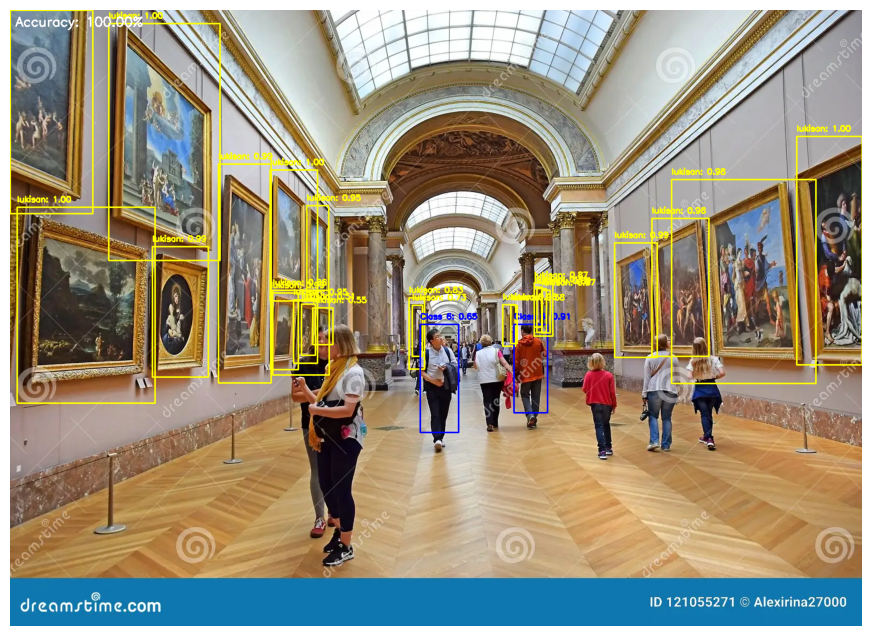

{3: 24, 6: 2}
Results saved to 'prediction_result.jpg'


In [11]:
def load_model(model_path, num_classes):
  # initialize model
  model = fasterrcnn_resnet50_fpn(pretrained = False)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # Load saved weights
  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint['model_state_dict'])

  return model

def predict_image(model, image_path, device, confidence_threshold = 0.50):
  # Load and preprocess the image
  image = cv.imread(image_path)
  if image is None:
        raise ValueError(f"Could not load image from {image_path}")
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

  # Convert to tensor and normalize
  image_tensor = torch.from_numpy(image).float() / 255.0
  image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0)

  # Move to device and set model to evaluation mode
  model = model.to(device)
  model.eval()
  image_tensor = image_tensor.to(device)

  # Get prediction
  with torch.no_grad():
      predictions = model(image_tensor)

  # Extract boxes, scores, and labels from predictions
  # Assuming predictions is a list of dictionaries, and the first element
  # contains the predictions for the input image
  boxes = predictions[0]['boxes'].cpu().numpy()
  scores = predictions[0]['scores'].cpu().numpy()
  labels = predictions[0]['labels'].cpu().numpy()

  # Filter predictions based on confidence threshold
  mask = scores >= confidence_threshold
  boxes = boxes[mask]
  scores = scores[mask]
  labels = labels[mask]

  # count objects
  label_tensor = torch.from_numpy(labels)
  unique_labels, counts = torch.unique(label_tensor, return_counts=True)

  # convert to dictionary
  counts_dict = {label.item(): count.item() for label, count in zip(unique_labels, counts)}

  return image, boxes, scores, labels, counts_dict

def draw_predictions(image, boxes, scores, labels, counts_dict, class_names=None):
    # Make a copy of the image to draw on
    image_draw = image.copy()

    # Define colors for different classes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

    # Total count for statistics
    total_predictions = len(scores)
    correct_predictions = sum([score >= 0.5 for score in scores])  # Confidence threshold

    # Draw each prediction
    for box, score, label in zip(boxes, scores, labels):
        # Convert box coordinates to integers
        box = box.astype(np.int64)

        # Get color for this class
        color = colors[label % len(colors)]

        # Draw box
        cv.rectangle(image_draw, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Prepare label text
        if class_names and label < len(class_names):
            label_text = f"{class_names[label]}: {score:.2f}"
        else:
            label_text = f"Class {label}: {score:.2f}"

        # Draw label
        cv.putText(image_draw, label_text, (box[0], box[1] - 10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Calculate and display precision (percentage of correct predictions)
    precision = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
    accuracy_text = f"Accuracy: {precision:.2f}%"

    # Display accuracy on the image
    cv.putText(image_draw, accuracy_text, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    return image_draw


def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Model path and number of classes (including background)
    model_path = '/kaggle/input/art-objects-counting/pytorch/default/1/best_model.pth'
    num_classes = 7

    # Class names (adjust these to match your classes)
    class_names = ['wayang','keris', 'batik', 'lukisan', 'gamelan']

    # Load model
    model = load_model(model_path, num_classes)
    model.to(device)

    # Path to test image
    test_image_path = '/kaggle/input/lovreads/louvre.webp'

    # Get predictions
    image, boxes, scores, labels, count_dict = predict_image(model, test_image_path, device, confidence_threshold=0.5)

    # Draw predictions with additional information
    result_image = draw_predictions(image, boxes, scores, labels, count_dict, class_names)


    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

    # Save result
    result_image_rgb = cv.cvtColor(result_image, cv.COLOR_RGB2BGR)
    cv.imwrite('prediction_result.jpg', result_image_rgb)
    print(count_dict)
    print("Results saved to 'prediction_result.jpg'")

if __name__ == "__main__":
    main()


# On a Video

In [3]:
import time

def process_video(model, video_path, output_path, device, confidence_threshold=0.5):
    model.eval()
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise IOError("Error opening video file")

    # video properties
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv.CAP_PROP_FPS))
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {width}x{height} at {fps}fps, {total_frames} total frames")

    # initialize video writer
    fourcc = cv.VideoWriter_fourcc(*'MJPG')
    out = cv.VideoWriter(os.path.join(output_path, 'output.avi'), fourcc, fps, (width, height))

    # process frame
    frame_count = 0
    processing_times = []  # To track processing speed
    start_time = time.time()

    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            frame_start_time = time.time()

            # Convert to tensor and normalize
            frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            image_tensor = torch.from_numpy(frame_rgb).float() / 255.0
            image_tensor = image_tensor.permute(2,0,1).unsqueeze(0).to(device)
            
            predictions = model(image_tensor)

            # process predictions
            boxes = predictions[0]['boxes'].cpu().numpy()
            scores = predictions[0]['scores'].cpu().numpy()
            labels = predictions[0]['labels'].cpu().numpy()

            # filter by conf
            mask = scores >= confidence_threshold
            boxes = boxes[mask]
            scores = scores[mask]
            labels = labels[mask]

            # draw prediction on frame
            for box, score, label in zip(boxes, scores, labels):
                box = box.astype(np.int64)
                x1, y1, x2, y2 = box
                cv.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
                label_text = f"Class {label}: {score:.2f}"
                cv.putText(frame, label_text, (x1, y1 - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

            out.write(frame)
            
            # Calculate and display progress
            frame_time = time.time() - frame_start_time
            processing_times.append(frame_time)
            avg_time = np.mean(processing_times[-10:])  # Average of last 10 frames
            fps_current = 1 / avg_time if avg_time > 0 else 0
            
            elapsed_time = time.time() - start_time
            estimated_total = (total_frames / frame_count) * elapsed_time
            remaining_time = estimated_total - elapsed_time
            
            print(f"\rProcessing frame {frame_count}/{total_frames} "
                  f"({(frame_count/total_frames)*100:.1f}%) "
                  f"| Current FPS: {fps_current:.1f} "
                  f"| Est. time remaining: {remaining_time/60:.1f} minutes", end='')

            # Optional: Display frame (if you're running locally)
            # cv.imshow('Processing...', frame)
            # if cv.waitKey(1) & 0xFF == ord('q'):
            #     break

    cap.release()
    out.release()
    # cv.destroyAllWindows()  # Uncomment if using imshow
    
    print(f"\n\nProcessing completed!")
    print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
    print(f"Average FPS: {frame_count/(time.time() - start_time):.1f}")
    print(f"Output saved to: {os.path.join(output_path, 'output.avi')}")

def get_model(num_classes):  # Define get_model within the same script
    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Relace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    
def main():
    num_classes = 7
    model = get_model(num_classes)
    model.load_state_dict(torch.load('/kaggle/input/art-objects-counting/pytorch/default/1/best_model.pth', 
                         map_location=torch.device('cpu'))['model_state_dict'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    # Process video
    video_path = "/kaggle/input/testing-gallery/2025-01-04 12-39-40.mp4"
    # Make sure this directory exists
    output_path = "/kaggle/working"
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    process_video(
        model=model,
        video_path=video_path,
        output_path=output_path,
        device=device,
        confidence_threshold=0.5
    )

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 228MB/s] 
<ipython-input-3-5b86173055af>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default valu

Using device: cuda
Video properties: 1920x1080 at 60fps, 5651 total frames
Processing frame 353/5651 (6.2%) | Current FPS: 7.9 | Est. time remaining: 11.5 minutes

KeyboardInterrupt: 